<a href="https://colab.research.google.com/github/jaysonlam/diabetes_prediction/blob/main/Diabetes_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd /content/drive/MyDrive/dataset/

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
data = pd.read_csv('nhgh.tsv', sep='\t')
data = data.drop(["seqn"], axis=1)

In [ ]:
data

In [ ]:
na_count_per_column = data.isna().sum()
print("NA count in each column:")
print(na_count_per_column)

Convert gh to binary value to indicate diabetic patients

In [ ]:
data["gh"] = data["gh"].apply(lambda x: 1 if x>=6.5 else 0)

In [ ]:
diabetic_data = data[data['gh'] == 1]
plt.hist(diabetic_data['age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Age Distribution of Diabetic Individuals')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.scatter(data['armc'], data['arml'], c=data['gh'], cmap='viridis')
plt.xlabel('Arm Circumference')
plt.ylabel('Arm length')
plt.title('Arm Circumference vs Arm length, Colored by Diabetic Status')
_ = plt.legend()

In [ ]:
gh_counts = data['gh'].groupby(data['re']).mean()
gh_counts.plot(kind='bar')
plt.title('Diabetic Ratio by Race')
plt.xlabel('Race')
_ = plt.ylabel('Ratio')

In [ ]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Possible features to remove are wt,armc,waist due to high correlation with bmi

In [ ]:
y = data["gh"]
data = data.drop(["gh"], axis=1)
y_values_count = y.value_counts()
print("Number of each value in gh column:")
print(y_values_count)

# Preprocessing Pipeline

In [ ]:
num_pipeline = Pipeline([
    ('impute', KNNImputer()),
])

In [ ]:
cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encode', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [ ]:
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
num_cols = data.select_dtypes(exclude=['object']).columns.tolist()

In [ ]:
data_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_cols),
    ('categorical', cat_pipeline, cat_cols),
])

## Code to handle class imbalance

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler,SMOTE
# from imblearn.pipeline import Pipeline as ResamplingPipeline

# resampling_pipeline = ResamplingPipeline([
#     ('preprocessing', data_pipeline),
#     ('undersample', RandomUnderSampler(sampling_strategy=0.1, random_state=42)),
#     #('upsample', RandomOverSampler(random_state=42)),
#     ('SMOTE',SMOTE(random_state=42))
# ])

# pre_X_train, pre_X_test, pre_y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)
# X_train, y_train = resampling_pipeline.fit_resample(pre_X_train, pre_y_train)
# X_test = pd.DataFrame(data=data_pipeline.fit_transform(pre_X_test))

In [ ]:
transformed_data = pd.DataFrame(data=data_pipeline.fit_transform(data))
X_train, X_test, y_train, y_test = train_test_split(transformed_data, y, test_size=0.2, random_state=42)
feature_names = data_pipeline.get_feature_names_out()

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Logistic Regression

In [ ]:
lr = Pipeline([('logistic_regression',LogisticRegression(random_state=42))])

# Define hyperparameters for grid search
param_grid = {
    'logistic_regression__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'logistic_regression__penalty': ['l2'],
    'logistic_regression__C': [0.001, 0.01, 0.1, 1, 10,100]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(lr, param_grid, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_lr = grid_search.best_estimator_
coefficients = best_lr.named_steps['logistic_regression'].coef_

# Predictions on the test set
y_pred = best_lr.predict(X_test)

# Print model details
print("Best hyperparameters:", grid_search.best_params_)

# Additional evaluation metrics
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [ ]:
# Print the sorted coefficients with feature names
coefficients_with_names = list(zip(feature_names, coefficients[0]))
sorted_coefficients = sorted(coefficients_with_names, key=lambda x: abs(x[1]), reverse=True)
print("Ranked coefficients:")
for feature, coefficient in sorted_coefficients:
    print(f"{feature}: {coefficient}")


# Decision Tree

Best Hyperparameters: {'ccp_alpha': 0.0007725203293579772, 'criterion': 'gini', 'max_depth': 3, 'max_features': None}
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1224
           1       0.72      0.72      0.72       135

    accuracy                           0.94      1359
   macro avg       0.84      0.84      0.84      1359
weighted avg       0.94      0.94      0.94      1359



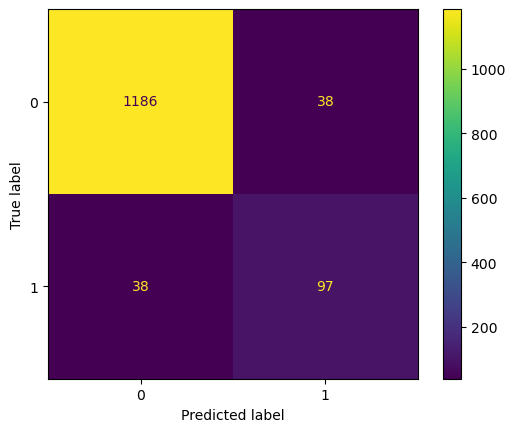

In [23]:
dt = DecisionTreeClassifier(random_state=42)

# Get cost-complexity pruning path
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Define hyperparameters for grid search
param_grid = {
    'ccp_alpha': ccp_alphas,
    'max_depth': [None, 2, 3, 5],
    'criterion': ["gini", "entropy"],
    'max_features': ['sqrt', 'log2', None],
}

# Perform grid search cross-validation
grid_search = GridSearchCV(dt, param_grid, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model
best_dt = grid_search.best_estimator_
best_alpha = best_dt.ccp_alpha
best_hyperparams = grid_search.best_params_

# Predictions on the test set
y_pred = best_dt.predict(X_test)

# Print model details
print("Best Hyperparameters:",best_hyperparams)

# Additional evaluation metrics
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

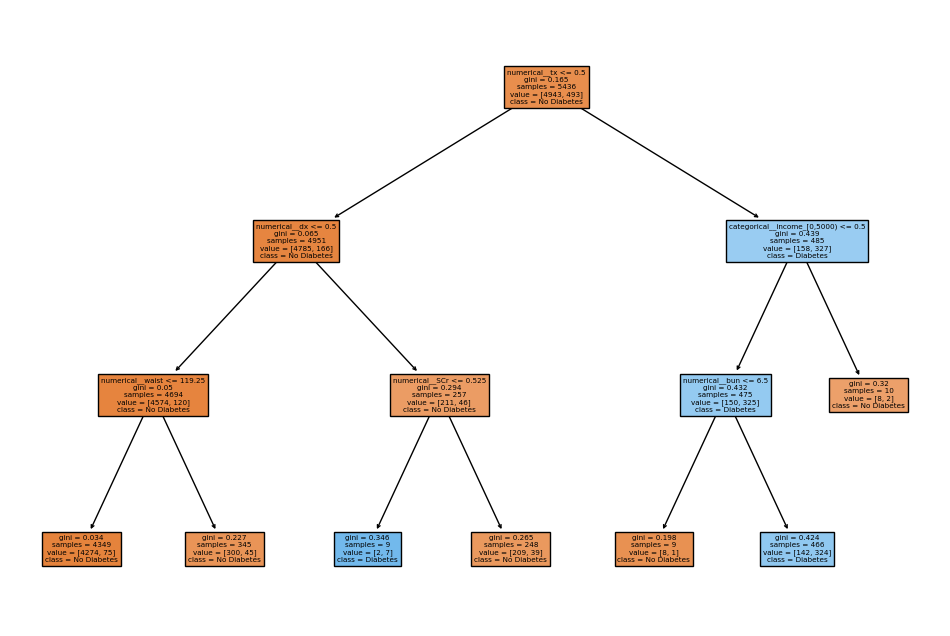

In [24]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
# Plot decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_dt, filled=True, feature_names=list(feature_names), class_names=['No Diabetes', 'Diabetes'])
plt.show()

In [25]:
# Display feature importances
importances = best_dt.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature Importances:")
for i, idx in enumerate(indices):
    if importances[idx]==0:
      break
    print(f"{i + 1}. {feature_names[idx]}: {importances[idx]}")

Feature Importances:
1. numerical__tx: 0.9074922515700354
2. numerical__dx: 0.0287044537833756
3. numerical__waist: 0.020495470832087047
4. numerical__SCr: 0.016736047569147646
5. numerical__bun: 0.015079634018240246
6. categorical__income_[0,5000): 0.011492142227114205


In [ ]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [25,50,100],
    'max_depth': [None, 2, 3 ,5],
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': [0.05,0.1,0.15]
}


# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model
print("Best parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Predictions on the test set
y_pred = best_rf.predict(X_test)

# Additional evaluation metrics
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(best_rf.estimators_[0], feature_names=list(feature_names), filled=True, class_names=['No Diabetes', 'Diabetes'])
plt.show()

In [ ]:
# Display feature importances
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature Importances:")
for i, idx in enumerate(indices):
    if importances[idx]==0:
      break
    print(f"{i + 1}. {feature_names[idx]}: {importances[idx]}")

# Model Evaluation

My assumptions for diabetes prediction is that having more false positives is better than false negatives because it is more important for diabetic patients to receive treatment. Thus, more emphasis should be placed on minimizing the value in the bottom-left of the confusion matrix while maintaining the total false positive and false negatives at a low value.

Based on the feature importance ranking retrieved from all models, I have identified tx and dx to be the most important variables. All models heavily rely on the value of tx(on insulin or diabetes meds) which is based on the initial medical diagnosis. This suggests that the data is not sufficient to predict the presence of diabetes.

This is evident as the best model among the three is the random forest. It has the best accuracy and f1-score compared to others models. By comparing the diagram between decision tree and random forest, it can be observed that the random forest is a pruned version of the decision tree which prevents overfitting. The logistic regression model has a higher false negative rate and lower accuracy compared to the other models.